In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
if torch.cuda.is_available():
    print("CUDA is enabled.")
    torch.device("cuda")

CUDA is enabled.


In [2]:
rgb = []
colors = []
categories = []
for data in open("labels.csv", "r").read().splitlines()[1:]:
    r, g, b, label = data.split(",")
    rgb.append((float(r)/255, float(g)/255, float(b)/255))
    colors.append(label)

categories = sorted(list(set(colors)))
colors_enc = [categories.index(c) for c in colors]
print(categories, colors_enc[0])

['Black', 'Blue', 'Brown', 'Green', 'Grey', 'Orange', 'Pink', 'Purple', 'Red', 'White', 'Yellow'] 1


In [13]:
# Initialization

inputs = torch.tensor(rgb).float()
labels = F.one_hot(torch.tensor(colors_enc)).float()
print(inputs.shape, labels.shape)

hidden_layer_dim = 50

W1 = torch.randn((3, hidden_layer_dim)) * 0.4 # * (5/3)/(3**0.5)
B1 = torch.randn((hidden_layer_dim)) * 0.1
W2 = torch.randn((hidden_layer_dim, labels.shape[1])) * 0.01

# BatchNorm parameters
bngain = torch.ones((1, hidden_layer_dim))
bnbias = torch.zeros((1, hidden_layer_dim))
bnmean_running = torch.zeros((1, hidden_layer_dim))
bnstd_running = torch.ones((1, hidden_layer_dim))

parameters = [W1, B1, W2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

torch.Size([5052, 3]) torch.Size([5052, 11])


In [14]:
for i in range(100000):
    hpreact = inputs @ W1 + B1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2
    loss = F.cross_entropy(logits.softmax(dim=1), labels)

    if i % 10000 == 0:
        print(loss)
    
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if i < 80000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # break

tensor(2.3977, grad_fn=<DivBackward1>)
tensor(1.7539, grad_fn=<DivBackward1>)
tensor(1.7363, grad_fn=<DivBackward1>)
tensor(1.7299, grad_fn=<DivBackward1>)
tensor(1.7267, grad_fn=<DivBackward1>)
tensor(1.7246, grad_fn=<DivBackward1>)
tensor(1.7232, grad_fn=<DivBackward1>)
tensor(1.7222, grad_fn=<DivBackward1>)
tensor(1.7213, grad_fn=<DivBackward1>)
tensor(1.7212, grad_fn=<DivBackward1>)


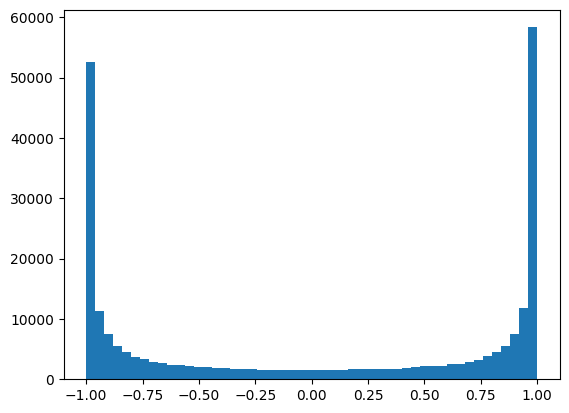

In [15]:
plt.hist(h.view(-1).tolist(), 50);

In [ ]:
color = torch.tensor([255,0,0]).float()
hpreact = color @ W1
hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
h = torch.tanh(hpreact)
logits = torch.tanh(h @ W2)
print(logits)
logits.softmax(dim=1)

tensor([[ 1.0000,  0.9549,  0.9983, -0.9902, -0.2624,  0.9999, -0.9923,  0.6749,
          0.9536,  0.9970,  0.9998]], grad_fn=<TanhBackward0>)


tensor([[0.1222, 0.1168, 0.1220, 0.0167, 0.0346, 0.1222, 0.0167, 0.0883, 0.1167,
         0.1218, 0.1222]], grad_fn=<SoftmaxBackward0>)

In [16]:
with torch.no_grad():
  # pass the training set through
  hpreact = inputs @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [17]:
with torch.no_grad():
  color = torch.tensor([0,255,0]).float() / 255
  hpreact = color @ W1 + B1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2
  # print(logits)
  probs = logits.softmax(dim=0)
  print("\n".join([f"{categories[i]}: {p.item():.4f}" for i, p in enumerate(probs)]))
  print(categories[torch.argmax(probs)])
  plt.pie([1], colors=[color]);
  plt.pie(probs, labels=categories, colors=categories);

RuntimeError: a Tensor with 11 elements cannot be converted to Scalar